In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import pandas as pd
from src.dali import Dataloader

train = pd.read_csv('data/train_chip_ids.csv')
dl = Dataloader(train.chip_id.values, batch_size=4)

In [58]:
batch = next(iter(dl))[0]
x1, x2, labels = batch['x1'], batch['x2'], batch['labels']

x1.shape, x2.shape

(torch.Size([4, 12, 256, 256, 2]), torch.Size([4, 12, 256, 256, 6]))

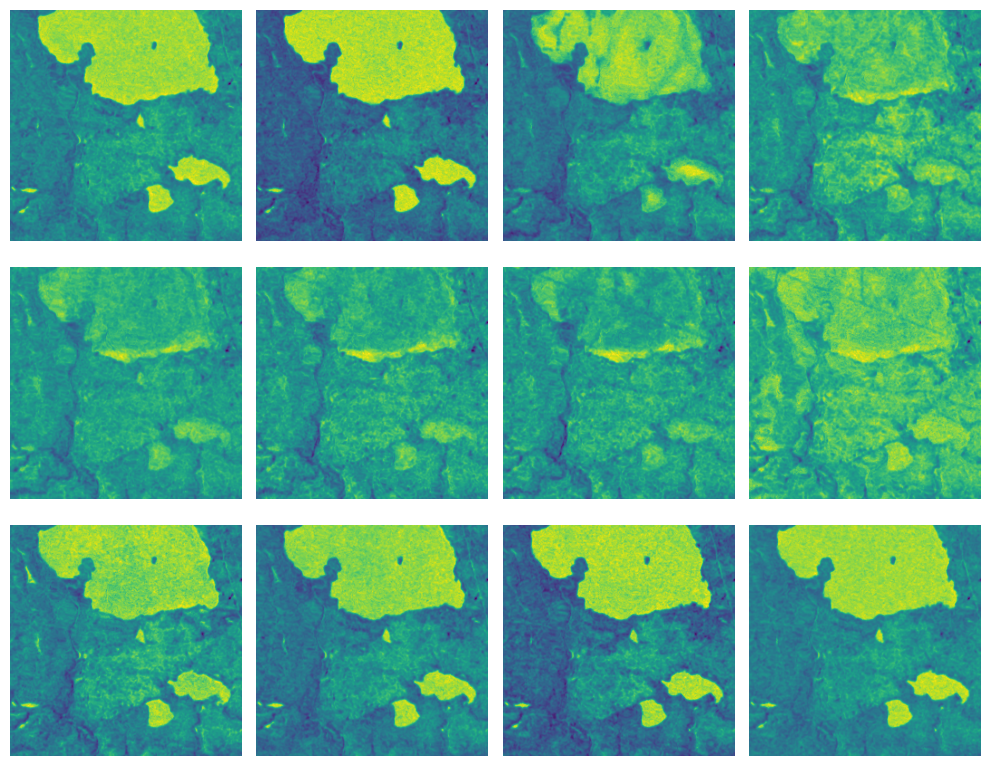

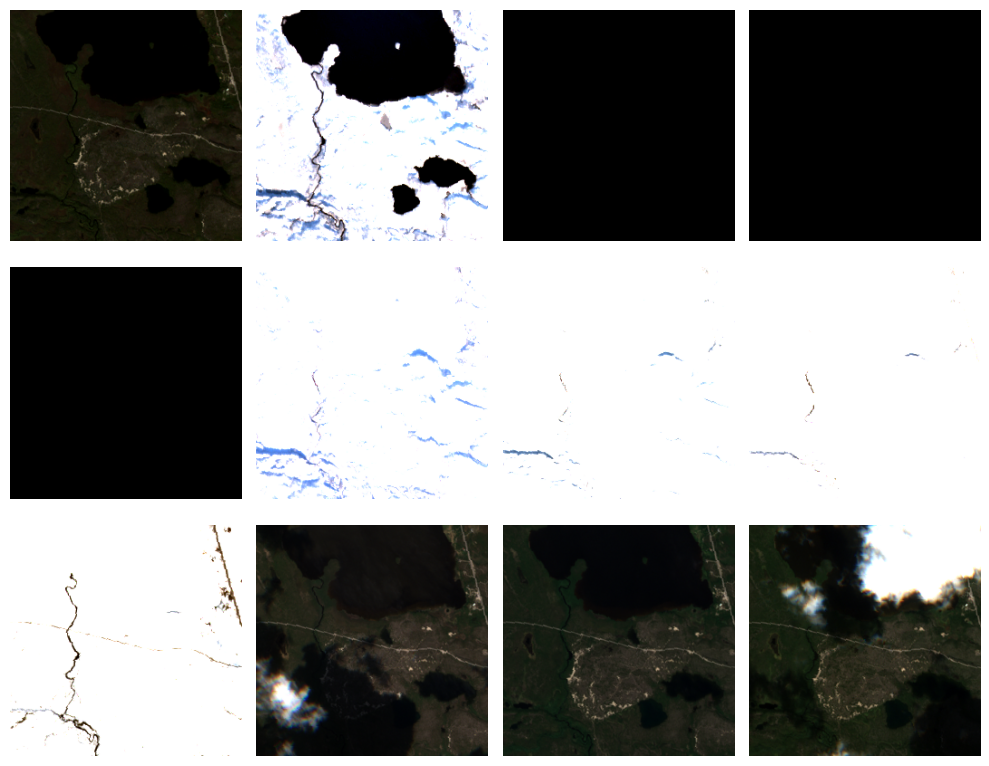

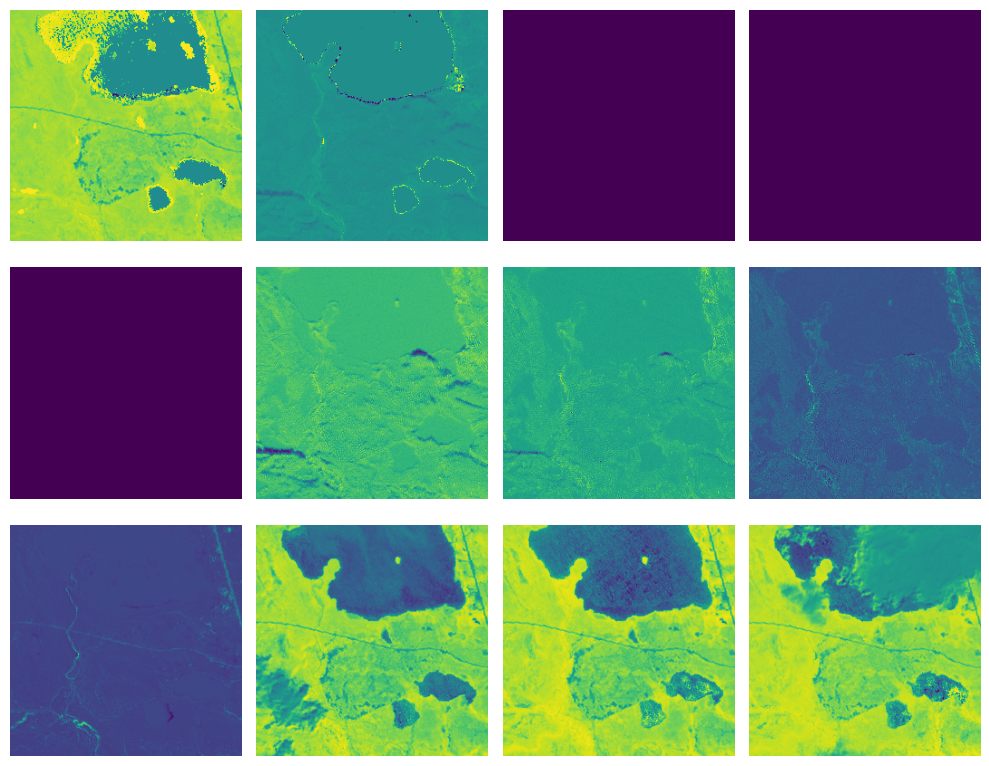

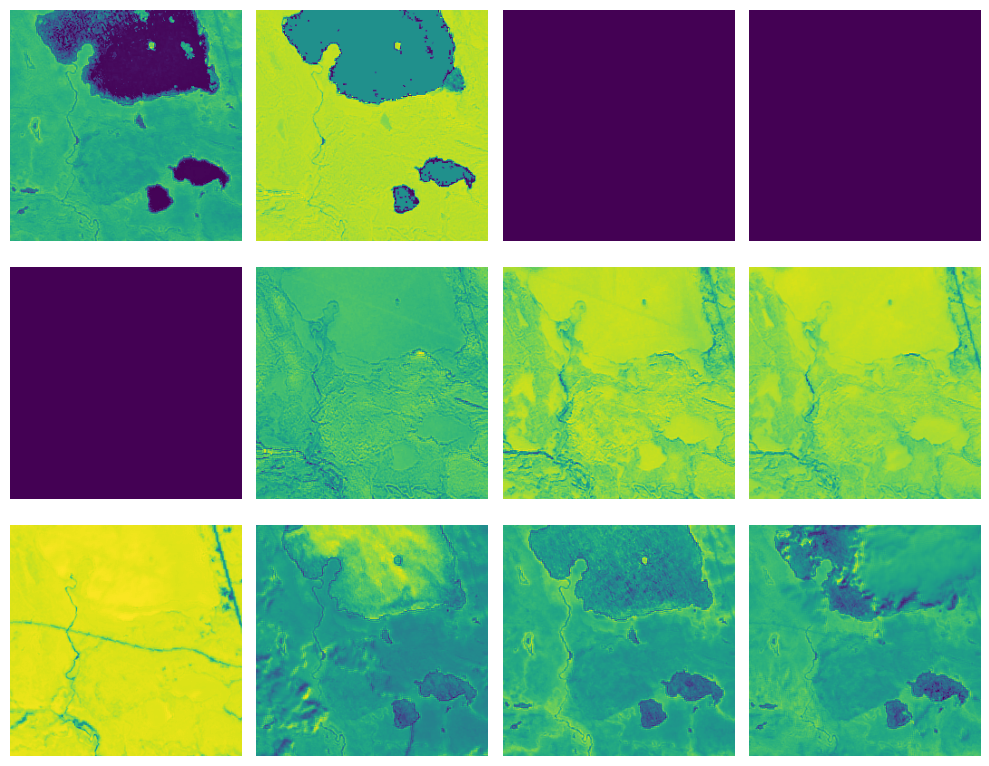

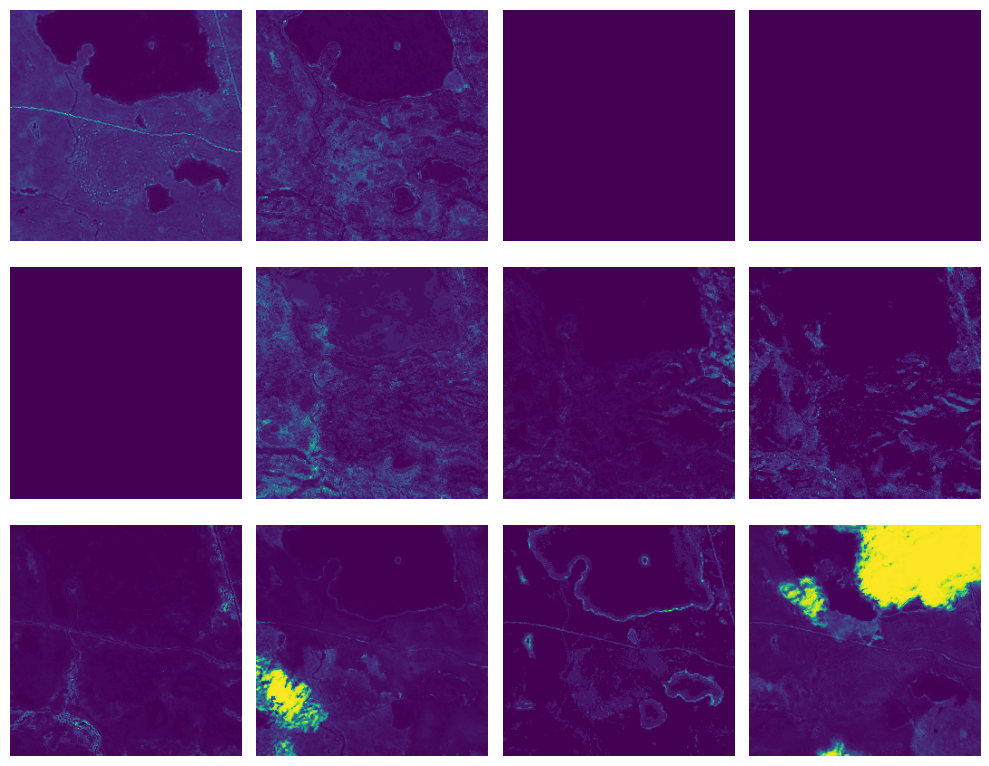

In [60]:
import matplotlib.pyplot as plt 

# dl = Dataloader(train.chip_id.values, batch_size=4, shuffle=False)
dl = Dataloader(train.chip_id.values, batch_size=4, shuffle=False, trans=True, seed=2)
batch = next(iter(dl))[0]
x1, x2, labels = batch['x1'].cpu(), batch['x2'].cpu(), batch['labels'].cpu()

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(x1[0][i*4+j][...,0])
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(x2[0][i*4+j][...,:3]) # rgb
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(x2[0][i*4+j][...,3]) # ndvi
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(x2[0][i*4+j][...,4]) # ndwi
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(3, 4, figsize=(10,8))
for i in range(3):
	for j in range(4):
		ax[i, j].imshow(x2[0][i*4+j][...,5]) # clouds
		ax[i, j].axis('off')
plt.tight_layout()
plt.show()

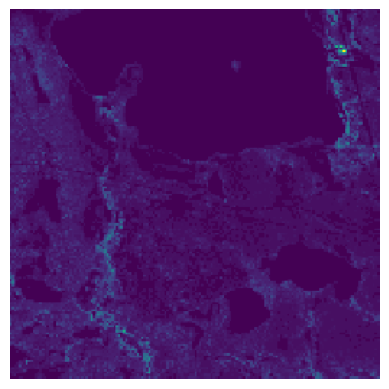

In [61]:
plt.imshow(labels[0])
plt.axis('off')
plt.show()

In [48]:
from src.models.unet_df2 import UNetDF2

model = UNetDF2()

outputs = model(x1, x2)

outputs.shape

/home/juan/miniconda3/envs/pt2/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


torch.Size([4, 256, 256])

In [49]:
import torch
from tqdm import tqdm

BATCH_SIZE = 4
EPOCHS = 500
USE_AMP=True

model = UNetDF2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

pbar = tqdm(range(1, EPOCHS+1))
for epoch in pbar:
    dl = Dataloader(train.chip_id.values, batch_size=BATCH_SIZE, shuffle=False)
    model.train()
    for batch_idx, data in enumerate(dl):
        batch_data = data[0]
        x1, x2, y = batch_data['x1'], batch_data['x2'], batch_data['labels'].squeeze(
            -1)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            y_hat = model(x1, x2)
            loss = torch.mean(torch.sqrt(
                torch.mean((y_hat - y)**2, dim=(1, 2))))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        metrics = torch.mean(torch.sqrt(torch.mean(
            (y_hat * 12905.3 - y * 12905.3)**2, dim=(1, 2))))
        break
    pbar.set_description(f'Epoch {epoch}/{EPOCHS} loss: {loss.item():.4f} metric: {metrics.item():.4f}')


Epoch 500/500 loss: 0.0022 metric: 28.6569: 100%|██████████| 500/500 [01:40<00:00,  4.96it/s] 


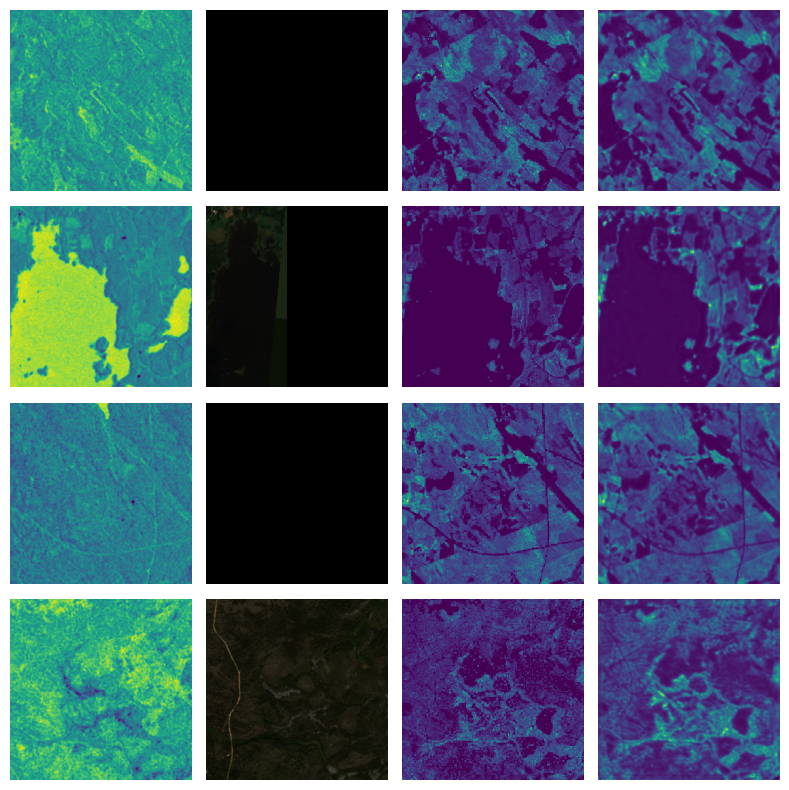

In [50]:
import matplotlib.pyplot as plt 

dl = Dataloader(train.chip_id.values, batch_size=4, shuffle=False)
batch = next(iter(dl))[0]
x1, x2, labels = batch['x1'].cpu(), batch['x2'].cpu(), batch['labels'].cpu()

model.eval()
model.cpu()
with torch.no_grad():
    preds = model(x1, x2)

fig = plt.figure(figsize=(8, 2*BATCH_SIZE))
for i in range(BATCH_SIZE):
    ax = plt.subplot(BATCH_SIZE, 4, 4*i+1)
    ax.imshow(x1[i][0][...,0])
    ax.axis('off')
    ax = plt.subplot(BATCH_SIZE, 4, 4*i+2)
    ax.imshow(x2[i][0][...,:3])
    ax.axis('off')
    ax = plt.subplot(BATCH_SIZE, 4, 4*i+3)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(BATCH_SIZE, 4, 4*i+4)
    ax.imshow(preds[i])
    ax.axis('off')
plt.tight_layout()
plt.show()